In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from re import sub
#from sklearn.preprocessing import power_transform

In [3]:
rma_expr = pd.read_csv("https://www.cancerrxgene.org/gdsc1000/GDSC1000_WebResources//Data/preprocessed/Cell_line_RMA_proc_basalExp.txt.zip", sep = "\t")
rma_expr = rma_expr.drop('GENE_title', axis = 1)
rma_expr= rma_expr.set_index('GENE_SYMBOLS')

In [2]:
ic50_data = pd.read_excel("ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/current_release/GDSC1_fitted_dose_response_25Feb20.xlsx")
ic50_data

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
0,GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.395685,0.982114,0.022521,-0.189576
1,GDSC1,281,12975300,684055,ES3,SIDM00265,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,3.140923,0.984816,0.031840,0.508635
2,GDSC1,281,12975647,684057,ES5,SIDM00263,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,3.968757,0.985693,0.026052,1.284229
3,GDSC1,281,12975980,684059,ES7,SIDM00269,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.692768,0.972699,0.110056,0.088760
4,GDSC1,281,12976330,684062,EW-11,SIDM00203,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.478678,0.944462,0.087011,-0.111820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310899,GDSC1,281,13269726,1660034,SNU-407,SIDM00214,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.0,4.820567,0.975376,0.032752,0.299720
310900,GDSC1,281,13269986,1660035,SNU-61,SIDM00194,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.0,5.785978,0.977001,0.040082,1.742423
310901,GDSC1,281,13270253,1660036,SNU-81,SIDM00193,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.0,5.393454,0.979140,0.042595,1.155838
310902,GDSC1,281,13270519,1674021,SNU-C5,SIDM00498,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.0,5.099131,0.982310,0.038664,0.716003


In [26]:
rma_cells = [int(x.split('.')[1]) for x in rma_expr.columns]

In [27]:
cell_id_matches = []

for cell_id in rma_cells:
    if cell_id in ic50_data['COSMIC_ID'].values:
        cell_id_matches.append(cell_id)
        
print(f'Number of matches: {len(cell_id_matches)} of {len(rma_cells)}')

Number of matches: 962 of 1018


In [48]:
rma_matches = np.isin(np.array(rma_cells), np.array(cell_id_matches))

rma_expr_matched = rma_expr.iloc[:,rma_matches]
rma_expr_matched.shape

(17737, 962)

In [33]:
ic50_matched = ic50_data.loc[ic50_data['COSMIC_ID'].isin(cell_id_matches)]
ic50_matched

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
0,GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.395685,0.982114,0.022521,-0.189576
1,GDSC1,281,12975300,684055,ES3,SIDM00265,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,3.140923,0.984816,0.031840,0.508635
2,GDSC1,281,12975647,684057,ES5,SIDM00263,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,3.968757,0.985693,0.026052,1.284229
3,GDSC1,281,12975980,684059,ES7,SIDM00269,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.692768,0.972699,0.110056,0.088760
4,GDSC1,281,12976330,684062,EW-11,SIDM00203,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.478678,0.944462,0.087011,-0.111820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310898,GDSC1,281,13269334,1659823,SNU-1040,SIDM00217,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.0,5.353963,0.977047,0.038387,1.096822
310899,GDSC1,281,13269726,1660034,SNU-407,SIDM00214,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.0,4.820567,0.975376,0.032752,0.299720
310900,GDSC1,281,13269986,1660035,SNU-61,SIDM00194,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.0,5.785978,0.977001,0.040082,1.742423
310901,GDSC1,281,13270253,1660036,SNU-81,SIDM00193,COREAD,1530,PFI-3,"SMARCA2, SMARCA4, PB1",Chromatin other,1025,Y,0.039063,10.0,5.393454,0.979140,0.042595,1.155838


In [35]:
len(ic50_matched['DRUG_NAME'].unique())

345

In [36]:
ic50_matched['DRUG_NAME'].unique()

array(['Erlotinib', 'Rapamycin', 'Sunitinib', 'PHA-665752', 'MG-132',
       'Paclitaxel', 'Cyclopamine', 'AZ628', 'Sorafenib', 'Tozasertib',
       'Imatinib', 'NVP-TAE684', 'Crizotinib', 'Saracatinib',
       'S-Trityl-L-cysteine', 'Z-LLNle-CHO', 'Dasatinib', 'GNF-2',
       'CGP-60474', 'CGP-082996', 'A-770041', 'WH-4-023', 'WZ-1-84',
       'BI-2536', 'BMS-536924', 'BMS-509744', 'CMK', 'Pyrimethamine',
       'JW-7-52-1', 'A-443654', 'GW843682X', 'Entinostat', 'Parthenolide',
       'GSK319347A', 'TGX221', 'Bortezomib', 'XMD8-85', 'Seliciclib',
       'Salubrinal', 'Lapatinib', 'GSK269962A', 'Doxorubicin',
       'Etoposide', 'Gemcitabine', 'Mitomycin-C', 'Vinorelbine',
       'NSC-87877', 'Bicalutamide', 'QS11', 'CP466722', 'Midostaurin',
       'CHIR-99021', 'Ponatinib', 'AZD6482', 'JNK-9L', 'PF-562271',
       'HG6-64-1', 'JQ1', 'JQ12', 'DMOG', 'FTI-277', 'OSU-03012',
       'Shikonin', 'AKT inhibitor VIII', 'Embelin', 'FH535', 'PAC-1',
       'IPA-3', 'GSK650394', 'BAY-61-3606'

In [49]:
rma_expr_matched = rma_expr_matched.T
rma_expr_matched['COSMIC_ID'] = [int(x.split('.')[1]) for x in rma_expr_matched.index]

In [52]:
rma_expr_matched = rma_expr_matched.loc[:, rma_expr_matched.columns.notna()]
rma_expr_matched

GENE_SYMBOLS,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,OR1D5,ZNF234,MYH4,LINC00526,PPY2,KRT18P55,POLRMTP1,UBL5P2,TBC1D3P5,COSMIC_ID
DATA.906826,7.632023,2.964585,10.379553,3.614794,3.380681,3.324692,3.566350,8.204530,5.235118,5.369039,...,3.134197,4.841169,2.628932,6.786925,2.997054,3.331134,3.130696,9.986616,3.073724,906826
DATA.687983,7.548671,2.777716,11.807341,4.066887,3.732485,3.152404,7.827172,6.616972,5.809264,7.209653,...,3.327528,4.570476,2.783441,5.317911,3.263745,2.992611,3.260982,9.002814,3.000182,687983
DATA.910927,8.712338,2.643508,9.880733,3.956230,3.236620,3.241246,2.931034,8.191246,5.426841,5.120747,...,3.326309,4.214729,2.603604,3.143006,3.112145,2.886574,3.176239,9.113243,2.916274,910927
DATA.1240138,7.797142,2.817923,9.883471,4.063701,3.558414,3.101247,7.211707,8.630643,5.617714,4.996434,...,2.921903,4.060761,2.619540,3.153896,3.151576,3.812119,3.074432,9.958284,3.256500,1240138
DATA.1240139,7.729268,2.957739,10.418840,4.341500,3.840373,3.001802,3.375422,8.296950,5.669418,4.180205,...,3.474086,4.869199,2.450375,3.652660,2.918475,3.412586,3.213545,9.938978,3.396126,1240139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DATA.1298157,8.441628,2.639276,11.463742,4.425849,4.384732,3.229511,3.571204,8.193000,5.671600,4.943996,...,3.402212,4.540545,2.595066,5.097882,3.102979,3.343723,3.007502,9.332193,3.435411,1298157
DATA.1480372,8.422922,2.879890,10.557777,3.550390,4.247189,3.176336,3.321811,8.901706,4.684851,4.215908,...,3.841095,4.062441,2.443743,4.243448,3.034131,3.412558,3.088841,10.742651,3.317945,1480372
DATA.1298533,8.089255,2.521169,10.792750,4.443337,3.071359,3.238305,5.209472,8.073389,5.643811,5.040952,...,3.221974,4.686370,2.603842,5.084844,2.981869,3.640390,2.847505,8.544696,3.174515,1298533
DATA.930299,3.112333,2.870468,9.873902,4.266828,3.230197,3.027742,3.407148,5.760610,5.834256,5.550722,...,3.116006,4.099547,2.531280,4.986124,2.992148,3.142641,2.832840,9.900550,3.243563,930299


In [137]:
def model_drug(drug, verbose = False, figure = False):
    ic50_sub = ic50_matched.loc[ic50_matched['DRUG_NAME'] == drug][['COSMIC_ID',
                                                                    'LN_IC50',
                                                                    'Z_SCORE']]
    df = pd.merge(ic50_sub, rma_expr_matched).set_index('COSMIC_ID')
    
    X = df.drop(['LN_IC50', 'Z_SCORE'], axis = 1)
    y = df['LN_IC50']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    train_data = lightgbm.Dataset(X_train, label = y_train)
    test_data = lightgbm.Dataset(X_test, label = y_test, reference = train_data)
    
    param = {'boosting_type': 'goss',
             'n_estimators': 500,
             'num_iterations': 500,
             'learning_rate': 0.05,
             'max_bin': 1024,
             'metric': 'l2',
             'objective': 'regression',
             'num_leaves': 50,
             'verbose': -1}
    
    bst = lightgbm.train(param,
                         train_data,
                         callbacks=[lightgbm.early_stopping(stopping_rounds=30, verbose = False)],
                         valid_sets = test_data)
    
    fit_predict = bst.predict(X_test)
    if verbose:
        mae = mean_absolute_error(fit_predict, y_test)
        test_range = max(y_test)-min(y_test)
        print(f'{drug}:\nMAE = {mae:.3} (range {test_range:.3})')
    if figure:
        fig, ax = plt.subplots(figsize = (16,8), ncols = 2)
        ax[0].scatter(y_test, fit_predict, color = 'black', alpha = 0.5)
        ax[0].ylabel = 'Predicted ln(IC50)'
        ax[0].xlabel = 'True ln(IC50)'
        ax[0].set_title(drug)
        lightgbm.plot_importance(bst, max_num_features=20, ax = ax[1])
        if figure == 'save':
            filename = sub('[^A-Za-z0-9-]+', '', drug)
            plt.savefig(f'{filename}.png')
    return bst, fit_predict, y_test

Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Rapamycin:
MAE = 1.43 (range 9.15)


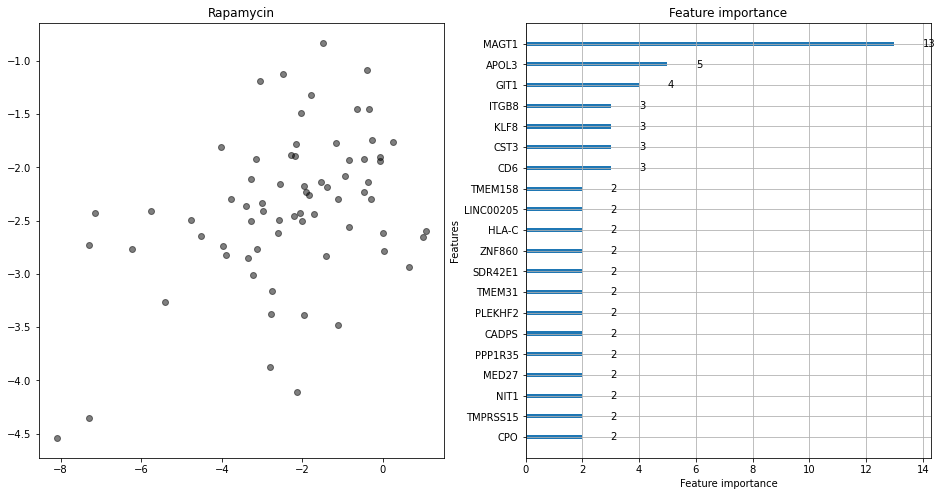

In [132]:
rapamycin_model = model_drug('Rapamycin', verbose = True, figure = True)

Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.577030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1846401
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 17419
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 2.746535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

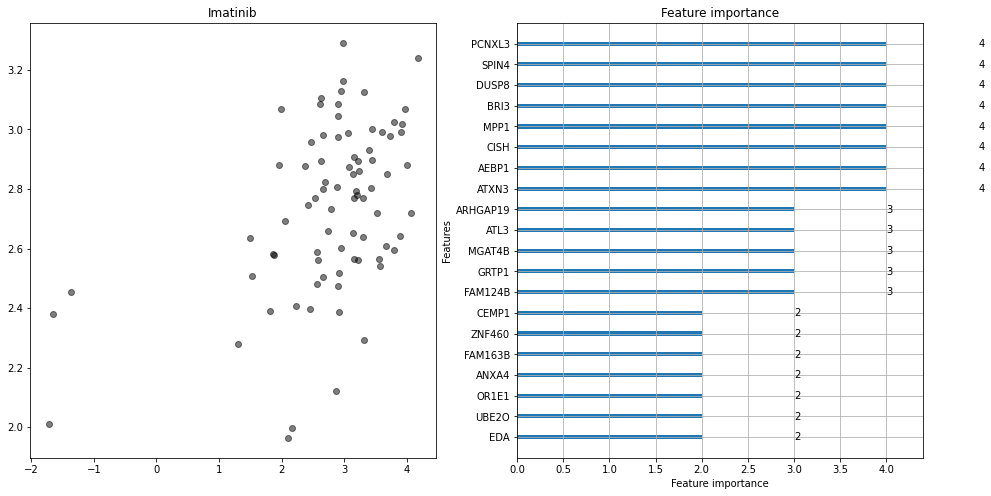

In [111]:
imatinib_model = model_drug('Imatinib', verbose = True)

Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Erlotinib:
MAE = 0.74 (range 6.7)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Rapamycin:
MAE = 1.57 (range 9.0)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Sunitinib:
MAE = 1.14 (range 9.18)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PHA-665752:
MAE = 0.573 (range 3.95)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


MG-132:
MAE = 1.07 (range 6.4)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Paclitaxel:
MAE = 1.57 (range 8.08)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Cyclopamine:
MAE = 0.75 (range 5.02)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZ628:
MAE = 1.07 (range 7.95)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Sorafenib:
MAE = 0.858 (range 6.27)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Tozasertib:
MAE = 1.68 (range 9.15)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Imatinib:
MAE = 0.492 (range 6.36)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


NVP-TAE684:
MAE = 0.964 (range 5.48)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Crizotinib:
MAE = 0.712 (range 5.41)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Saracatinib:
MAE = 0.87 (range 6.16)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


S-Trityl-L-cysteine:
MAE = 1.08 (range 5.74)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Z-LLNle-CHO:
MAE = 0.988 (range 6.8)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Dasatinib:
MAE = 1.69 (range 10.2)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


GNF-2:
MAE = 0.592 (range 6.03)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CGP-60474:
MAE = 1.04 (range 7.16)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CGP-082996:
MAE = 0.76 (range 4.8)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


A-770041:
MAE = 1.29 (range 8.69)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


WH-4-023:
MAE = 1.58 (range 10.5)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


WZ-1-84:
MAE = 0.734 (range 5.1)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


BI-2536:
MAE = 1.11 (range 5.97)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


BMS-536924:
MAE = 1.15 (range 7.33)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


BMS-509744:
MAE = 0.778 (range 4.44)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CMK:
MAE = 0.821 (range 4.68)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Pyrimethamine:
MAE = 1.2 (range 6.85)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


JW-7-52-1:
MAE = 1.53 (range 7.15)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


A-443654:
MAE = 0.974 (range 5.9)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


GW843682X:
MAE = 1.41 (range 6.73)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Entinostat:
MAE = 1.1 (range 7.28)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Parthenolide:
MAE = 0.915 (range 4.74)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


GSK319347A:
MAE = 0.545 (range 3.29)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


TGX221:
MAE = 0.816 (range 8.07)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Bortezomib:
MAE = 1.09 (range 6.7)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


XMD8-85:
MAE = 0.854 (range 6.11)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Seliciclib:
MAE = 0.808 (range 4.6)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Salubrinal:
MAE = 0.729 (range 4.78)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Lapatinib:
MAE = 0.569 (range 3.97)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


GSK269962A:
MAE = 0.94 (range 8.87)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Doxorubicin:
MAE = 1.07 (range 8.74)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Etoposide:
MAE = 1.54 (range 8.62)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Gemcitabine:
MAE = 1.63 (range 10.7)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Mitomycin-C:
MAE = 1.05 (range 6.91)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Vinorelbine:
MAE = 1.12 (range 8.21)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


NSC-87877:
MAE = 0.606 (range 4.32)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Bicalutamide:
MAE = 0.928 (range 5.53)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


QS11:
MAE = 1.04 (range 6.13)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CP466722:
MAE = 0.922 (range 6.1)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Midostaurin:
MAE = 0.939 (range 6.17)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CHIR-99021:
MAE = 0.788 (range 7.31)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Ponatinib:
MAE = 1.01 (range 11.5)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD6482:
MAE = 0.962 (range 7.99)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


JNK-9L:
MAE = 0.666 (range 5.05)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PF-562271:
MAE = 0.759 (range 5.19)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


HG6-64-1:
MAE = 1.17 (range 9.11)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


JQ1:
MAE = 1.38 (range 7.56)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


JQ12:
MAE = 1.31 (range 8.54)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


DMOG:
MAE = 0.968 (range 7.19)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


FTI-277:
MAE = 0.538 (range 4.22)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


OSU-03012:
MAE = 0.821 (range 6.77)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Shikonin:
MAE = 0.897 (range 8.98)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AKT inhibitor VIII:
MAE = 0.961 (range 7.8)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Embelin:
MAE = 0.832 (range 6.24)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


FH535:
MAE = 0.864 (range 7.7)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PAC-1:
MAE = 0.915 (range 4.79)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


IPA-3:
MAE = 1.18 (range 6.74)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


GSK650394:
MAE = 1.28 (range 6.61)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


BAY-61-3606:
MAE = 1.07 (range 8.49)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


5-Fluorouracil:
MAE = 1.2 (range 8.81)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Thapsigargin:
MAE = 1.46 (range 9.7)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Obatoclax Mesylate:
MAE = 1.28 (range 10.6)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


BMS-754807:
MAE = 1.26 (range 8.99)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Linsitinib:
MAE = 1.09 (range 7.53)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Bexarotene:
MAE = 0.861 (range 9.87)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Bleomycin:
MAE = 1.79 (range 10.7)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


LFM-A13:
MAE = 0.571 (range 3.73)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


GW-2580:
MAE = 0.443 (range 3.87)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Luminespib:
MAE = 1.17 (range 7.34)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Phenformin:
MAE = 1.37 (range 10.3)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Bryostatin 1:
MAE = 0.616 (range 4.43)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Pazopanib:
MAE = 1.03 (range 8.69)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Dacinostat:
MAE = 0.833 (range 7.02)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Epothilone B:
MAE = 1.45 (range 9.32)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


GSK1904529A:
MAE = 0.531 (range 4.6)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


BMS-345541:
MAE = 0.676 (range 5.77)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Tipifarnib:
MAE = 1.22 (range 8.19)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Avagacestat:
MAE = 0.804 (range 6.34)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Ruxolitinib:
MAE = 0.518 (range 9.44)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AS601245:
MAE = 0.937 (range 7.08)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Ispinesib Mesylate:
MAE = 1.22 (range 6.99)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


TL-2-105:
MAE = 0.862 (range 6.81)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AT-7519:
MAE = 1.18 (range 8.37)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


TAK-715:
MAE = 0.739 (range 5.45)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


BX-912:
MAE = 1.02 (range 8.1)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


ZSTK474:
MAE = 1.24 (range 9.14)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AS605240:
MAE = 1.1 (range 10.6)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Genentech Cpd 10:
MAE = 1.1 (range 7.81)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


GSK1070916:
MAE = 1.34 (range 10.8)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Enzastaurin:
MAE = 1.2 (range 7.13)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


GSK429286A:
MAE = 0.783 (range 6.85)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


FMK:
MAE = 0.502 (range 3.64)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


QL-XII-47:
MAE = 1.28 (range 7.87)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


IC-87114:
MAE = 0.554 (range 5.24)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Idelalisib:
MAE = 0.914 (range 7.68)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


UNC0638:
MAE = 0.935 (range 7.25)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Cabozantinib:
MAE = 0.887 (range 6.38)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


WZ3105:
MAE = 1.08 (range 7.65)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


XMD14-99:
MAE = 0.579 (range 5.24)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Quizartinib:
MAE = 0.608 (range 8.73)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CP724714:
MAE = 0.625 (range 8.11)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


JW-7-24-1:
MAE = 0.985 (range 7.71)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


NPK76-II-72-1:
MAE = 1.15 (range 8.56)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


STF-62247:
MAE = 0.654 (range 4.4)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


NG-25:
MAE = 1.07 (range 11.0)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


TL-1-85:
MAE = 1.01 (range 11.1)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


VX-11e:
MAE = 1.02 (range 8.36)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


FR-180204:
MAE = 0.658 (range 6.99)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


ACY-1215:
MAE = 0.825 (range 7.29)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Tubastatin A:
MAE = 0.752 (range 6.27)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Zibotentan:
MAE = 0.421 (range 5.29)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Sepantronium bromide:
MAE = 1.54 (range 11.0)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


NSC-207895:
MAE = 1.15 (range 7.15)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


VNLG/124:
MAE = 0.573 (range 5.73)


FileNotFoundError: [Errno 2] No such file or directory: 'VNLG/124.png'

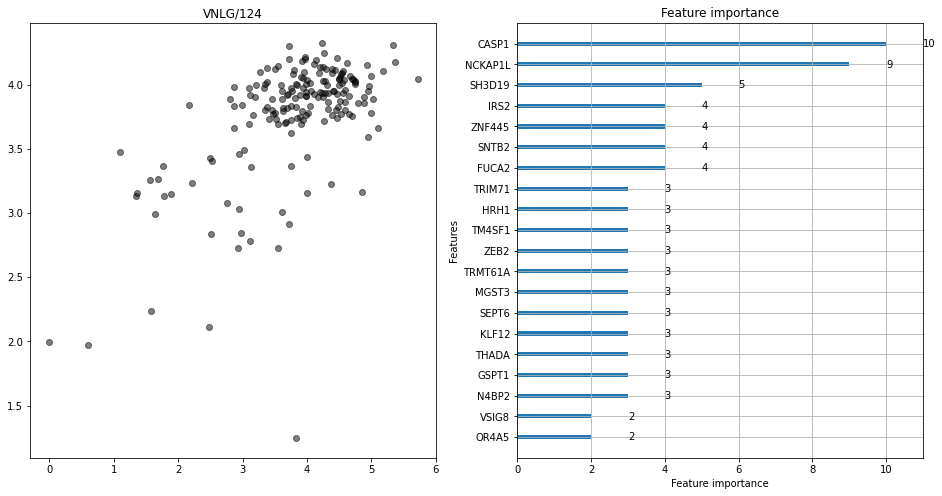

In [136]:
all_models = dict()

for drug in ic50_matched['DRUG_NAME'].unique():
    all_models[drug] = model_drug(drug, verbose = True, figure = 'save')
    plt.close()

In [139]:
for drug in ic50_matched['DRUG_NAME'].unique():
    if drug in all_models.keys():
        pass
    else:
        all_models[drug] = model_drug(drug, verbose = True, figure = 'save')
        plt.close()

Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


VNLG/124:
MAE = 0.584 (range 7.21)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AR-42:
MAE = 1.04 (range 9.52)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CUDC-101:
MAE = 1.25 (range 9.74)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Belinostat:
MAE = 1.35 (range 9.33)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


I-BET-762:
MAE = 1.13 (range 7.62)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CAY10603:
MAE = 1.15 (range 9.43)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Linifanib:
MAE = 0.579 (range 10.2)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


BIX02189:
MAE = 0.826 (range 5.99)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Alectinib:
MAE = 0.668 (range 10.3)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Pelitinib:
MAE = 1.43 (range 8.31)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Omipalisib:
MAE = 1.35 (range 10.2)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


JNJ38877605:
MAE = 0.758 (range 6.46)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


SU11274:
MAE = 0.885 (range 6.61)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


KIN001-236:
MAE = 0.632 (range 5.18)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


KIN001-244:
MAE = 0.813 (range 6.53)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


WHI-P97:
MAE = 0.768 (range 5.09)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


KIN001-042:
MAE = 0.581 (range 6.34)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


KIN001-260:
MAE = 0.79 (range 9.0)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


KIN001-266:
MAE = 0.793 (range 5.58)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Masitinib:
MAE = 0.78 (range 8.92)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Amuvatinib:
MAE = 1.07 (range 8.92)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


MPS-1-IN-1:
MAE = 0.922 (range 8.52)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


NVP-BHG712:
MAE = 1.06 (range 10.3)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


OSI-930:
MAE = 0.715 (range 9.46)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


OSI-027:
MAE = 1.59 (range 10.4)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CX-5461:
MAE = 1.41 (range 8.59)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PHA-793887:
MAE = 1.26 (range 7.91)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PI-103:
MAE = 1.59 (range 9.25)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PIK-93:
MAE = 0.963 (range 9.43)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


SB52334:
MAE = 1.04 (range 6.31)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


TPCA-1:
MAE = 1.17 (range 10.3)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Fedratinib:
MAE = 1.12 (range 8.54)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Foretinib:
MAE = 0.997 (range 9.3)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Y-39983:
MAE = 0.976 (range 7.65)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


YM201636:
MAE = 0.882 (range 6.9)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Tivozanib:
MAE = 0.451 (range 4.91)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


WYE-125132:
MAE = 1.53 (range 9.66)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


GSK690693:
MAE = 1.12 (range 9.39)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


SNX-2112:
MAE = 1.33 (range 9.14)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


QL-XI-92:
MAE = 0.842 (range 6.46)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


XMD13-2:
MAE = 0.872 (range 7.12)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


QL-X-138:
MAE = 1.2 (range 8.02)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


XMD15-27:
MAE = 0.606 (range 5.19)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


T0901317:
MAE = 0.666 (range 9.58)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Selisistat:
MAE = 0.417 (range 3.43)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Tenovin-6:
MAE = 0.674 (range 6.17)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


THZ-2-49:
MAE = 1.64 (range 9.04)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


KIN001-270:
MAE = 0.605 (range 4.93)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


THZ-2-102-1:
MAE = 1.75 (range 12.3)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AT7867:
MAE = 0.938 (range 7.51)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CI-1033:
MAE = 1.03 (range 8.73)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PF-00299804:
MAE = 0.81 (range 7.85)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


TWS119:
MAE = 0.983 (range 7.61)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Torin 2:
MAE = 1.25 (range 9.42)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Pilaralisib:
MAE = 0.693 (range 5.67)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


GSK1059615:
MAE = 1.08 (range 9.57)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Voxtalisib:
MAE = 0.685 (range 3.96)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Brivanib, BMS-540215:
MAE = 0.731 (range 7.44)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


BIBF-1120:
MAE = 1.12 (range 10.4)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AST-1306:
MAE = 0.906 (range 8.42)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Apitolisib:
MAE = 1.1 (range 8.74)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


LIMK1 inhibitor BMS4:
MAE = 0.751 (range 8.54)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


kb NB 142-70:
MAE = 0.833 (range 6.67)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Sphingosine Kinase 1 Inhibitor II:
MAE = 0.385 (range 3.01)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


eEF2K Inhibitor, A-484954:
MAE = 0.388 (range 2.76)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


MetAP2 Inhibitor, A832234:
MAE = 0.617 (range 5.6)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Venotoclax:
MAE = 0.577 (range 8.77)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CPI-613:
MAE = 0.662 (range 4.76)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CAY10566:
MAE = 0.686 (range 6.01)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Ara-G:
MAE = 0.5 (range 6.14)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Pemetrexed:
MAE = 1.14 (range 9.19)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Alisertib:
MAE = 1.14 (range 8.4)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Flavopiridol:
MAE = 0.776 (range 7.52)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


C-75:
MAE = 0.857 (range 5.09)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CAP-232, TT-232, TLN-232:
MAE = 0.922 (range 4.84)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Trichostatin A:
MAE = 0.871 (range 6.55)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Panobinostat:
MAE = 0.898 (range 7.93)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


LCL161:
MAE = 0.808 (range 9.17)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


IMD-0354:
MAE = 0.843 (range 7.52)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


MIM1:
MAE = 0.685 (range 5.49)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


ETP-45835:
MAE = 0.468 (range 4.6)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CD532:
MAE = 0.602 (range 8.79)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


NSC319726:
MAE = 1.65 (range 9.94)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


ARRY-520:
MAE = 1.68 (range 9.6)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


SB505124:
MAE = 1.02 (range 6.33)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


A-83-01:
MAE = 0.63 (range 4.62)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


LDN-193189:
MAE = 0.472 (range 5.8)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


FTY-720:
MAE = 0.539 (range 5.41)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


BAM7:
MAE = 0.608 (range 3.97)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AGI-6780:
MAE = 0.505 (range 3.76)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Kobe2602:
MAE = 0.689 (range 5.05)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


LGK974:
MAE = 0.569 (range 4.76)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Wnt-C59:
MAE = 0.528 (range 4.18)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


RU-SKI 43:
MAE = 0.77 (range 5.03)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AICA Ribonucleotide:
MAE = 0.848 (range 6.36)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Vinblastine:
MAE = 0.924 (range 7.3)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Cisplatin:
MAE = 0.898 (range 9.32)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Cytarabine:
MAE = 1.13 (range 7.86)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Docetaxel:
MAE = 0.849 (range 7.04)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Methotrexate:
MAE = 1.05 (range 7.47)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Tretinoin:
MAE = 0.814 (range 10.0)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Gefitinib:
MAE = 0.728 (range 6.2)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Navitoclax:
MAE = 1.16 (range 8.06)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Vorinostat:
MAE = 0.686 (range 6.61)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Nilotinib:
MAE = 0.706 (range 11.1)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Refametinib:
MAE = 0.844 (range 9.31)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CI-1040:
MAE = 0.847 (range 8.68)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Temsirolimus:
MAE = 1.06 (range 8.09)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Olaparib:
MAE = 0.689 (range 6.36)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Veliparib:
MAE = 0.5 (range 6.93)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Bosutinib:
MAE = 0.955 (range 6.63)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Lenalidomide:
MAE = 0.506 (range 3.8)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Axitinib:
MAE = 0.792 (range 5.94)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD7762:
MAE = 0.735 (range 11.1)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


GW441756:
MAE = 0.771 (range 9.18)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Lestaurtinib:
MAE = 1.0 (range 7.3)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


SB216763:
MAE = 0.609 (range 4.08)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Tanespimycin:
MAE = 1.06 (range 8.86)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


VX-702:
MAE = 0.566 (range 9.38)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Motesanib:
MAE = 0.721 (range 6.56)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


KU-55933:
MAE = 0.7 (range 5.31)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Elesclomol:
MAE = 1.32 (range 10.1)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Afatinib:
MAE = 1.71 (range 12.3)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Vismodegib:
MAE = 0.633 (range 3.68)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PLX-4720:
MAE = 0.698 (range 7.55)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


BX795:
MAE = 0.859 (range 6.9)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


NU7441:
MAE = 0.728 (range 4.6)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


SL0101:
MAE = 0.658 (range 5.16)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Doramapimod:
MAE = 0.661 (range 4.42)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


JNK Inhibitor VIII:
MAE = 0.629 (range 4.48)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Wee1 Inhibitor:
MAE = 0.826 (range 5.87)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Nutlin-3a (-):
MAE = 0.741 (range 5.53)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Mirin:
MAE = 0.933 (range 5.84)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PD173074:
MAE = 0.775 (range 8.65)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


ZM447439:
MAE = 0.892 (range 5.93)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


RO-3306:
MAE = 0.803 (range 5.67)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


MK-2206:
MAE = 1.06 (range 7.08)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Palbociclib:
MAE = 1.04 (range 7.17)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Dactolisib:
MAE = 0.755 (range 7.65)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Pictilisib:
MAE = 0.915 (range 8.38)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD8055:
MAE = 0.815 (range 6.34)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PD0325901:
MAE = 1.22 (range 8.01)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


SB590885:
MAE = 0.672 (range 8.3)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Selumetinib:
MAE = 1.12 (range 9.09)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CCT007093:
MAE = 0.538 (range 5.1)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


EHT-1864:
MAE = 0.687 (range 5.87)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Cetuximab:
MAE = 0.63 (range 5.96)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PF-4708671:
MAE = 0.707 (range 4.68)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Serdemetan:
MAE = 0.727 (range 6.59)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD4547:
MAE = 0.854 (range 9.81)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Capivasertib:
MAE = 1.24 (range 9.66)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


HG-5-113-01:
MAE = 0.68 (range 4.63)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


HG-5-88-01:
MAE = 0.892 (range 8.08)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


TW 37:
MAE = 0.824 (range 7.37)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


XMD11-85h:
MAE = 0.728 (range 4.07)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


ZG-10:
MAE = 0.72 (range 5.94)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


XMD8-92:
MAE = 0.702 (range 3.37)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


QL-VIII-58:
MAE = 0.932 (range 7.34)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


CCT-018159:
MAE = 0.751 (range 5.35)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Rucaparib:
MAE = 0.793 (range 6.26)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZ20:
MAE = 0.819 (range 6.05)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


KU-60019:
MAE = 0.732 (range 4.93)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Tamoxifen:
MAE = 0.583 (range 5.58)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


QL-XII-61:
MAE = 0.743 (range 4.23)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PFI-1:
MAE = 0.803 (range 5.55)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


IOX2:
MAE = 0.496 (range 4.48)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


YK-4-279:
MAE = 0.93 (range 6.3)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


(5Z)-7-Oxozeaenol:
MAE = 0.914 (range 10.5)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Piperlongumine:
MAE = 0.623 (range 4.86)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Daporinad:
MAE = 2.24 (range 10.3)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Talazoparib:
MAE = 1.1 (range 9.15)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


rTRAIL:
MAE = 1.08 (range 6.8)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


UNC1215:
MAE = 0.354 (range 4.05)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


UNC0642:
MAE = 0.4 (range 3.51)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


SGC0946:
MAE = 0.397 (range 3.05)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


ICL1100013:
MAE = 1.27 (range 8.93)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


XAV939:
MAE = 0.602 (range 4.91)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Trametinib:
MAE = 1.39 (range 10.1)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Dabrafenib:
MAE = 1.1 (range 10.6)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Temozolomide:
MAE = 0.488 (range 4.4)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Bleomycin (50 uM):
MAE = 1.28 (range 10.2)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD3514:
MAE = 0.715 (range 4.19)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Bleomycin (10 uM):
MAE = 1.14 (range 9.12)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD6738:
MAE = 0.786 (range 5.66)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD5438:
MAE = 0.666 (range 6.26)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD6094:
MAE = 0.473 (range 4.7)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Dyrk1b_0191:
MAE = 0.782 (range 5.12)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD4877:
MAE = 1.05 (range 8.99)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


EphB4_9721:
MAE = 0.997 (range 9.43)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Fulvestrant:
MAE = 0.693 (range 7.37)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD8931:
MAE = 0.966 (range 8.96)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


FEN1_3940:
MAE = 0.636 (range 6.07)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


FGFR_0939:
MAE = 0.766 (range 6.73)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


FGFR_3831:
MAE = 0.878 (range 6.78)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


BPTES:
MAE = 0.922 (range 8.64)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD7969:
MAE = 0.861 (range 7.2)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD5582:
MAE = 1.4 (range 10.8)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


IAP_5620:
MAE = 1.2 (range 10.7)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


IAP_7638:
MAE = 0.891 (range 11.3)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


IGFR_3801:
MAE = 1.34 (range 9.6)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD1480:
MAE = 0.772 (range 7.27)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


JAK1_3715:
MAE = 0.623 (range 4.72)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


JAK3_7406:
MAE = 0.888 (range 6.34)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


MCT1_6447:
MAE = 0.72 (range 9.41)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


MCT4_1422:
MAE = 0.589 (range 4.69)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD2014:
MAE = 1.04 (range 7.59)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD8186:
MAE = 0.852 (range 6.64)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD8835:
MAE = 0.848 (range 6.4)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PI3Ka_4409:
MAE = 0.872 (range 6.28)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD1208:
MAE = 0.785 (range 8.63)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PLK_6522:
MAE = 1.14 (range 7.94)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


RAF_9304:
MAE = 0.806 (range 7.6)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PARP_9495:
MAE = 0.987 (range 5.9)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PARP_0108:
MAE = 1.22 (range 8.15)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PARP_9482:
MAE = 1.4 (range 11.2)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


TANK_1366:
MAE = 0.622 (range 5.16)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


AZD1332:
MAE = 0.708 (range 7.21)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


TTK_3146:
MAE = 0.673 (range 5.51)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


SN-38:
MAE = 1.07 (range 11.0)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


Pevonedistat:
MAE = 1.17 (range 6.33)


Found `num_iterations` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


PFI-3:
MAE = 0.423 (range 4.36)


In [143]:
def r_squared(predicted, true):
    mean = np.mean(true)
    true_diff_sq = np.square(true - mean)
    pred_diff_sq = np.square(true - predicted)
    return 1-(np.sum(pred_diff_sq)/np.sum(true_diff_sq))

In [144]:
models_r_sq = dict([(x, r_squared(y[1], y[2])) for x, y in all_models.items()])

In [159]:
[(x,y) for x,y in models_r_sq.items() if y > 0.4]

[('AZ628', 0.4545206040415508),
 ('WZ3105', 0.42039447374983263),
 ('NPK76-II-72-1', 0.4413552073322673),
 ('Tubastatin A', 0.49800175781916645),
 ('PIK-93', 0.4365811548079159),
 ('Venotoclax', 0.47169388792786493),
 ('Methotrexate', 0.40236704786107724),
 ('Refametinib', 0.5634817779312296),
 ('AZD7762', 0.5309885261253418),
 ('Tanespimycin', 0.4416455405537729),
 ('Nutlin-3a (-)', 0.4349178687025781),
 ('Trametinib', 0.5094058188989272),
 ('Dabrafenib', 0.4946783285973053),
 ('SN-38', 0.4368254477157164)]

In [155]:
def plot_test(drug):
    bst, fit_predict, y_test = all_models[drug]
    fig, ax = plt.subplots(figsize = (16,8), ncols = 2)
    ax[0].scatter(y_test, fit_predict, color = 'black', alpha = 0.5)
    ax[0].ylabel = 'Predicted ln(IC50)'
    ax[0].xlabel = 'True ln(IC50)'
    ax[0].set_title(drug)
    lightgbm.plot_importance(bst, max_num_features=20, ax = ax[1])

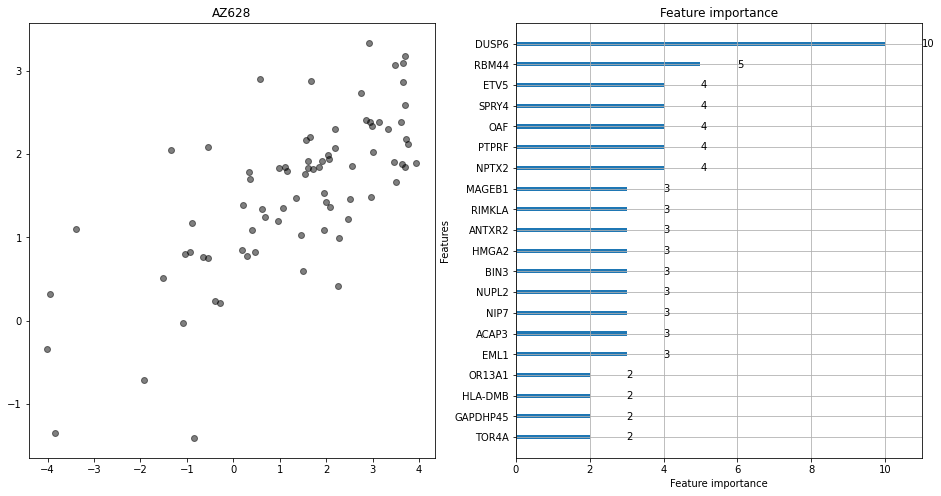

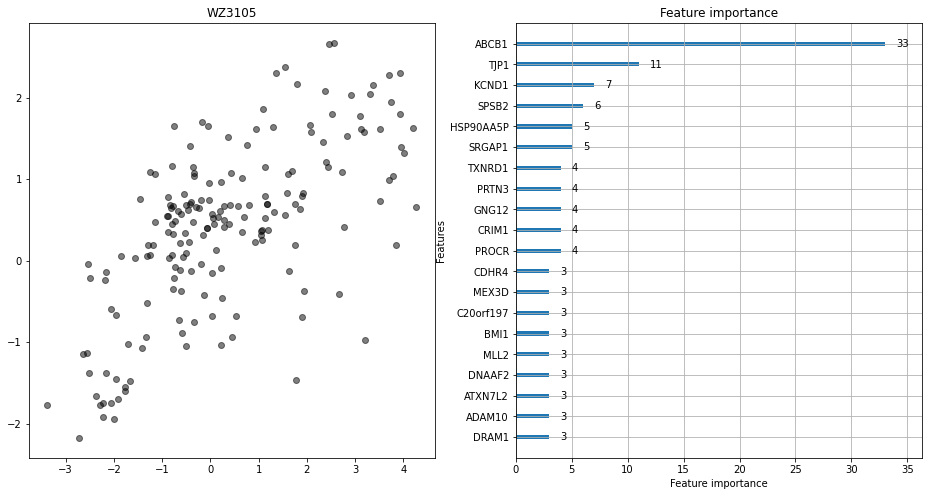

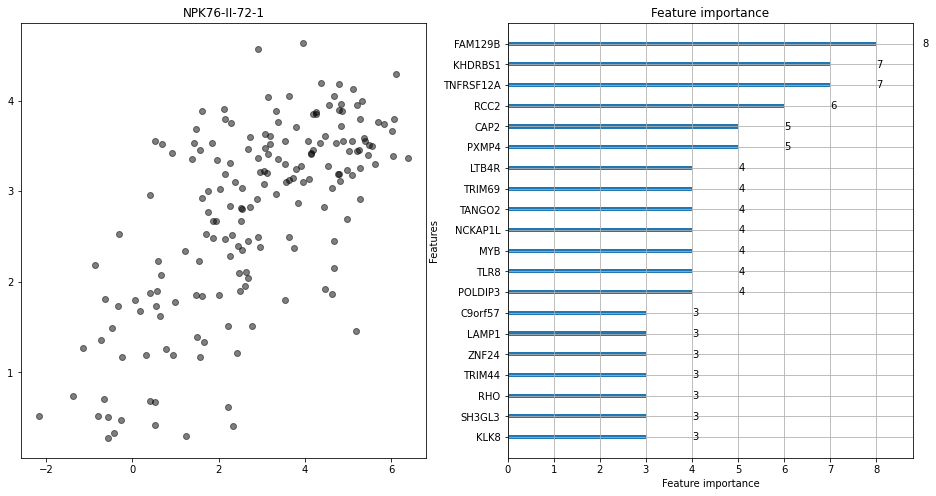

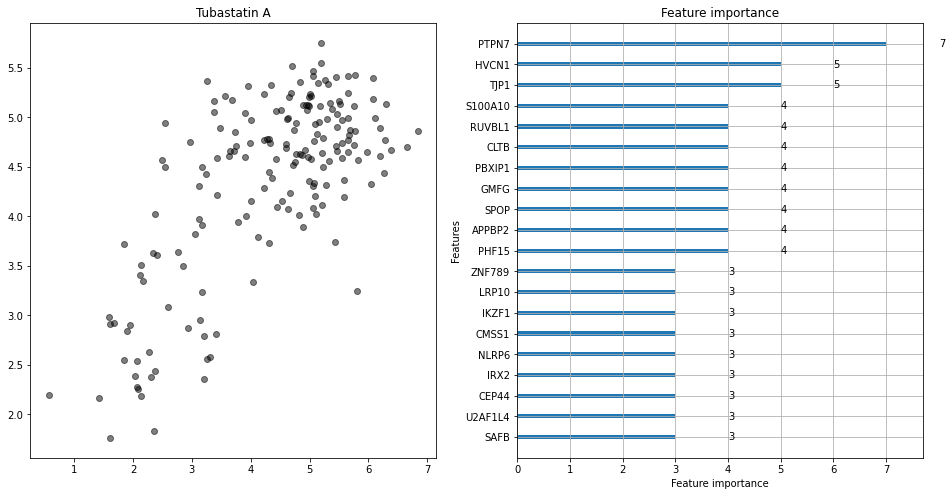

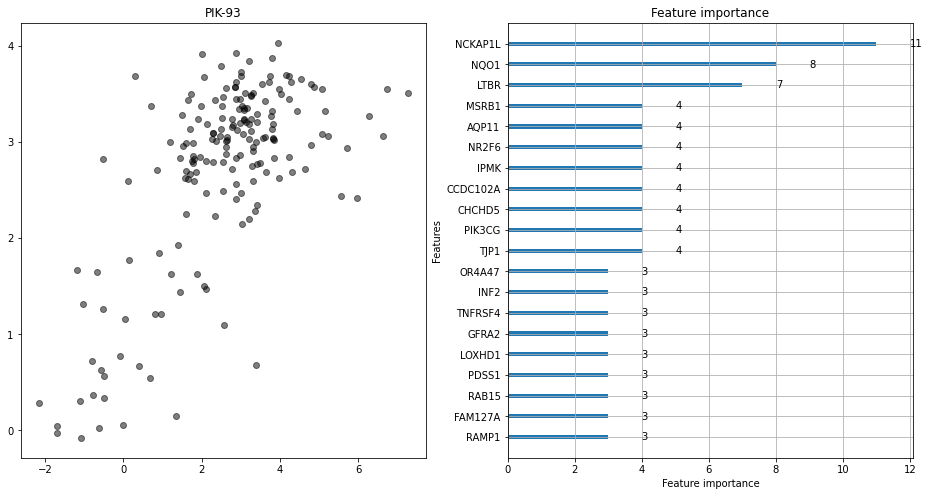

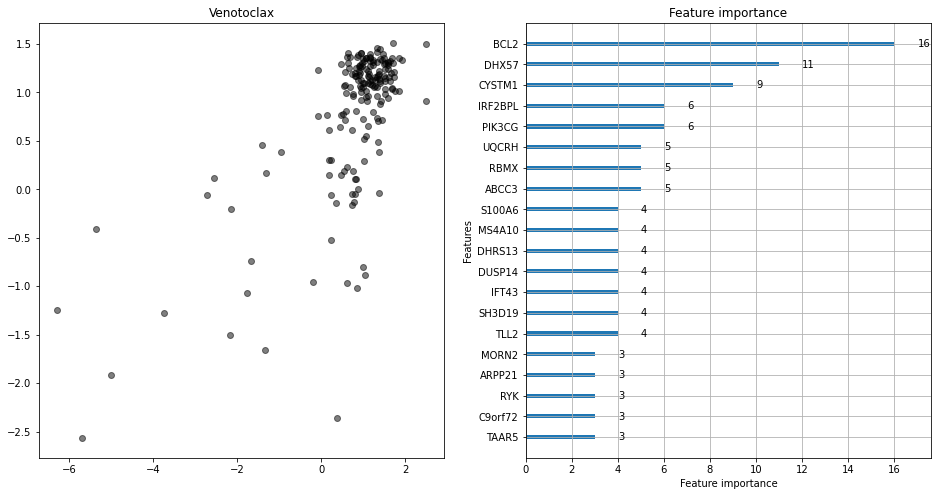

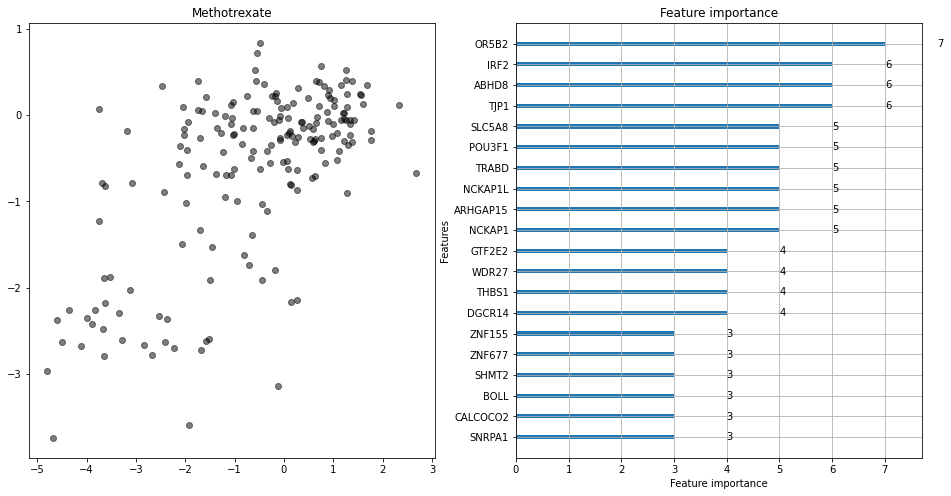

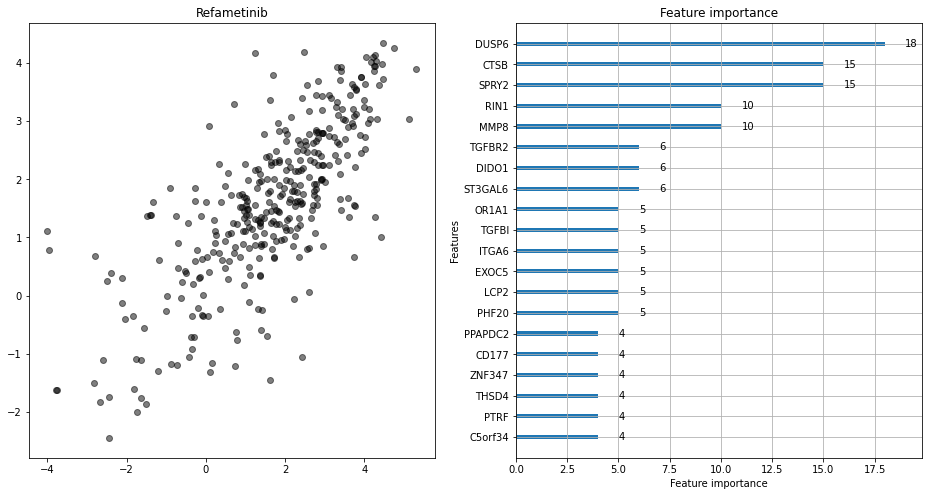

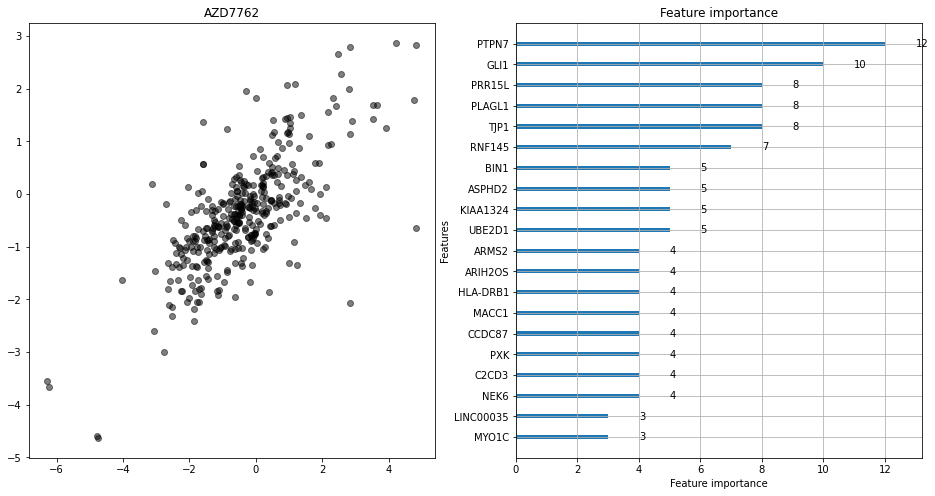

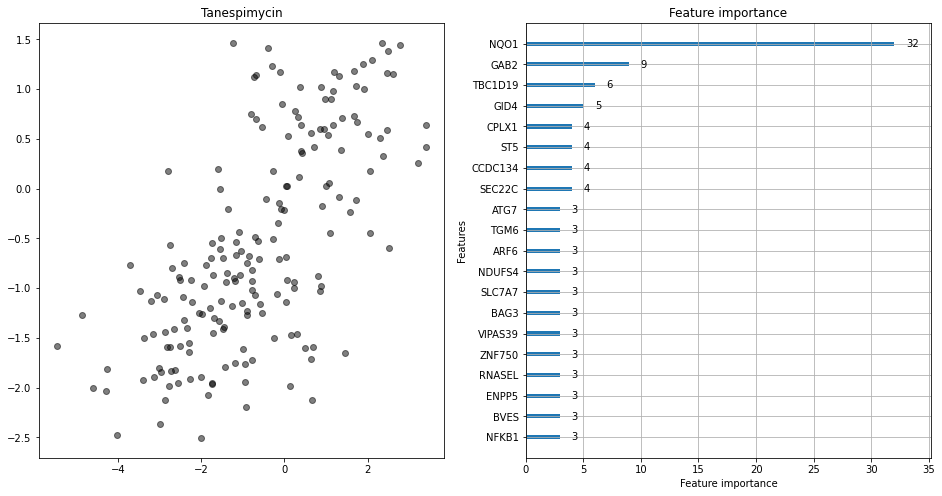

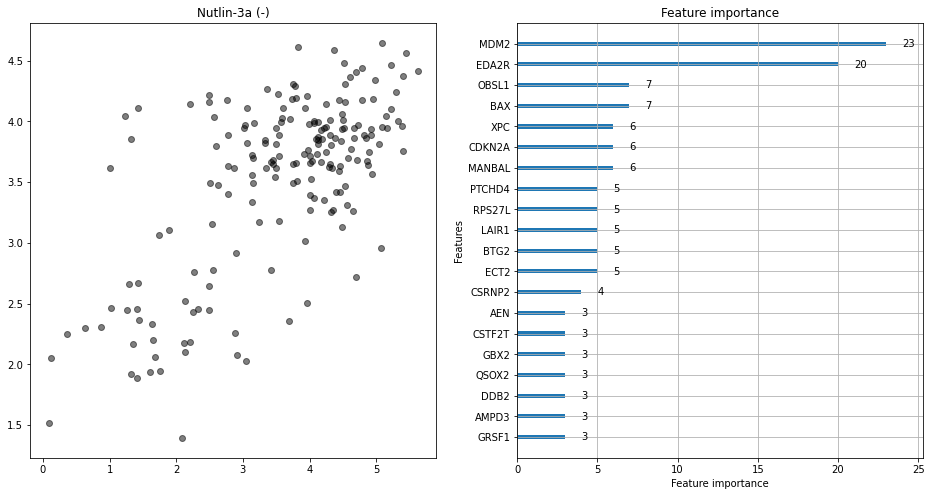

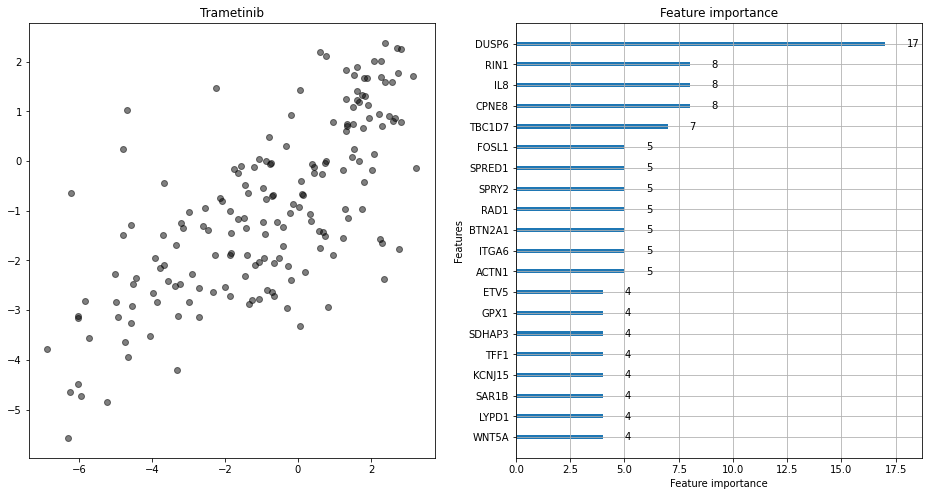

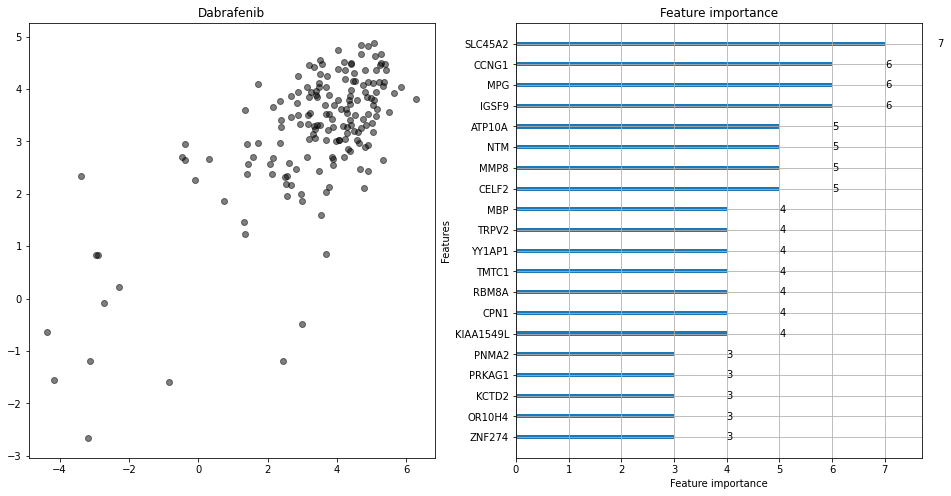

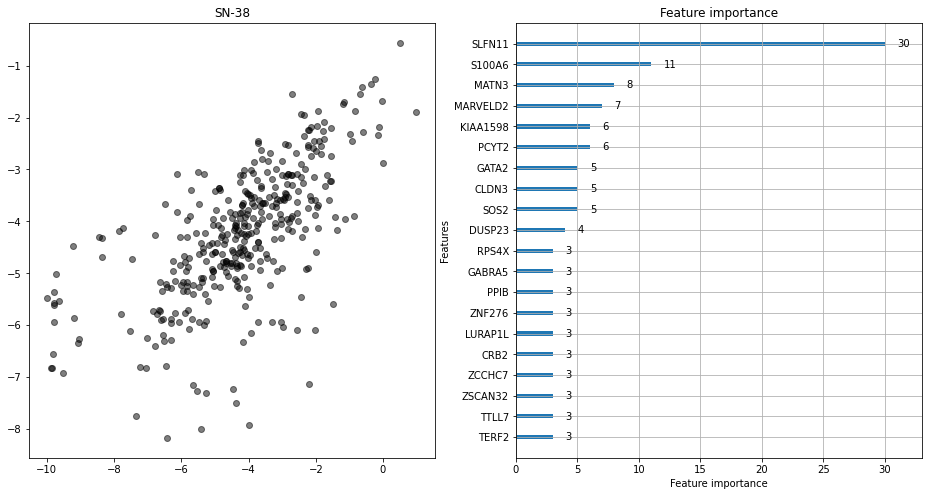

In [161]:
for drug_name in [x for x,y in models_r_sq.items() if y > 0.4]:
    plot_test(drug_name)

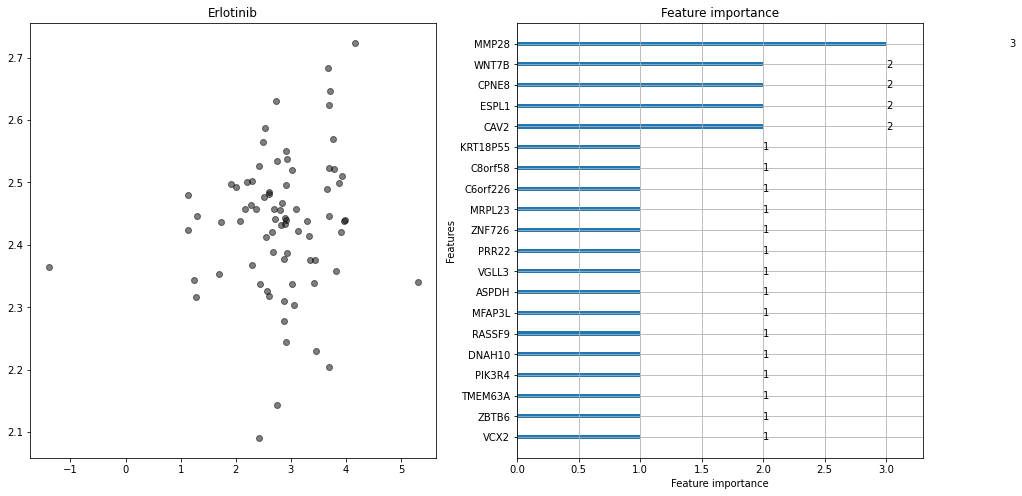

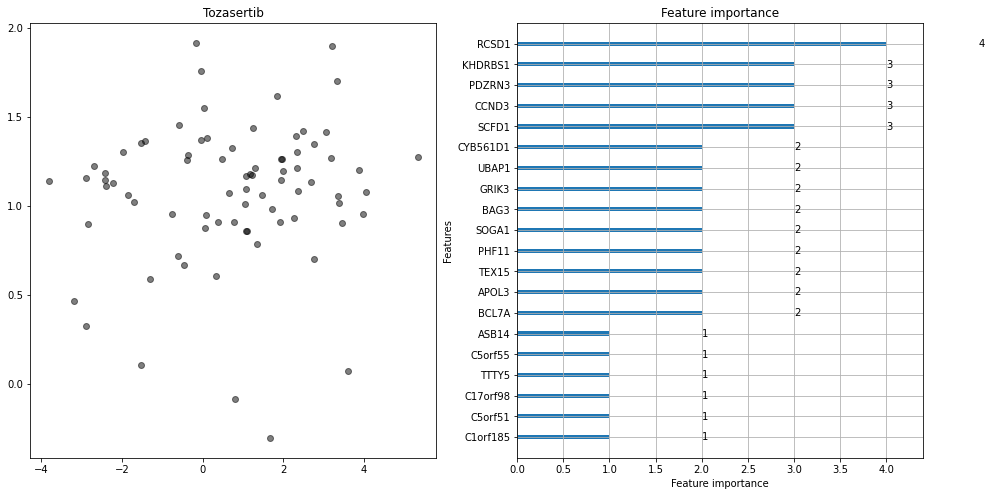

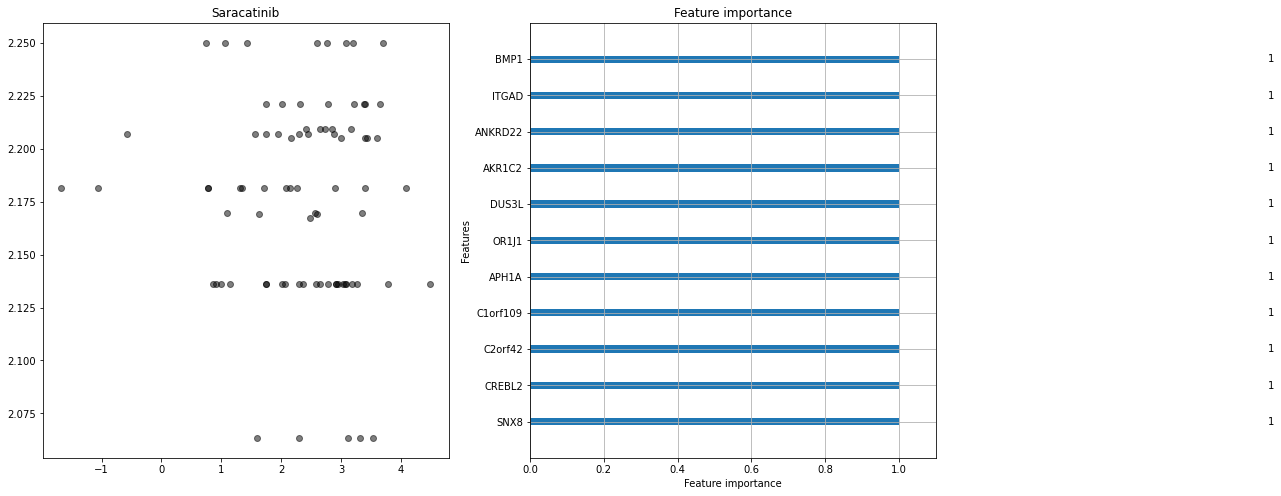

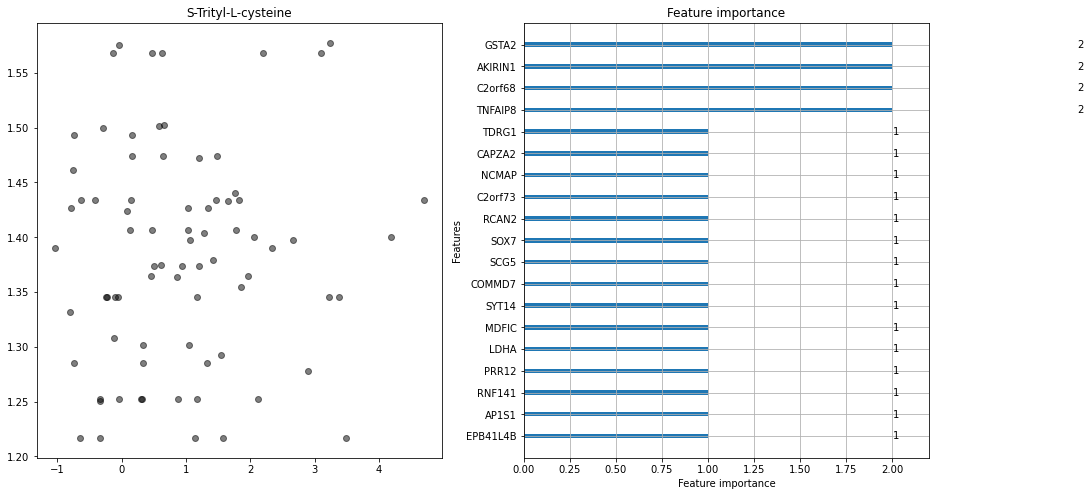

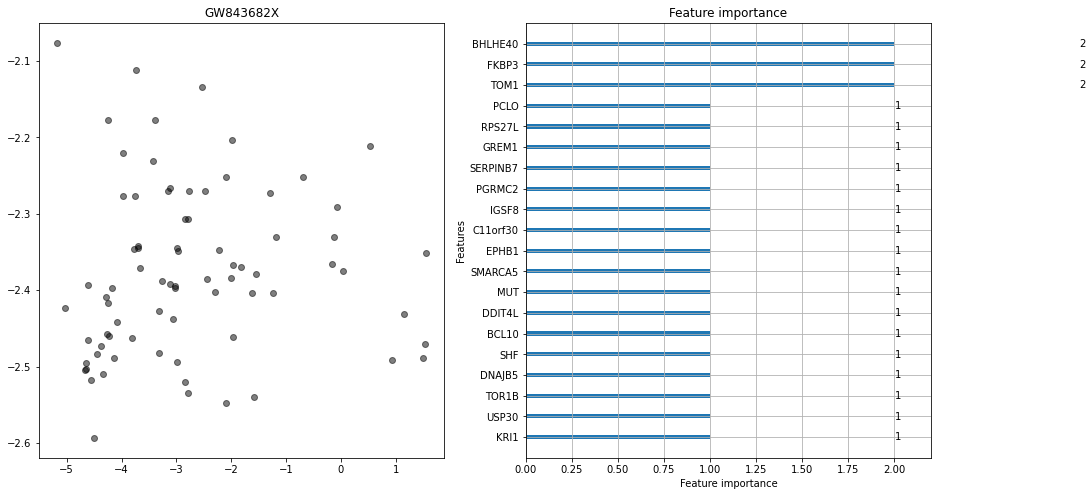

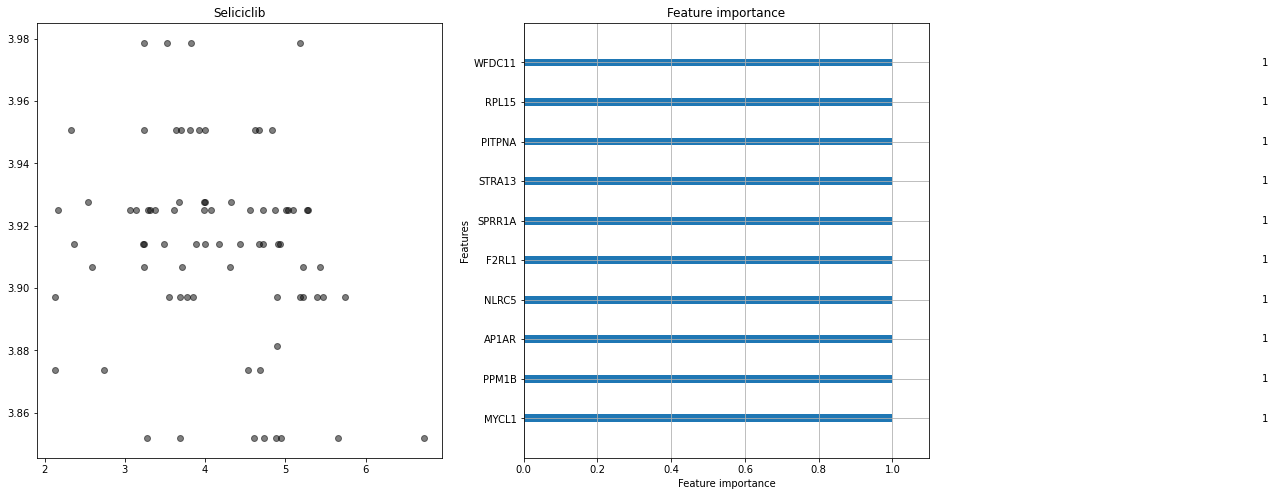

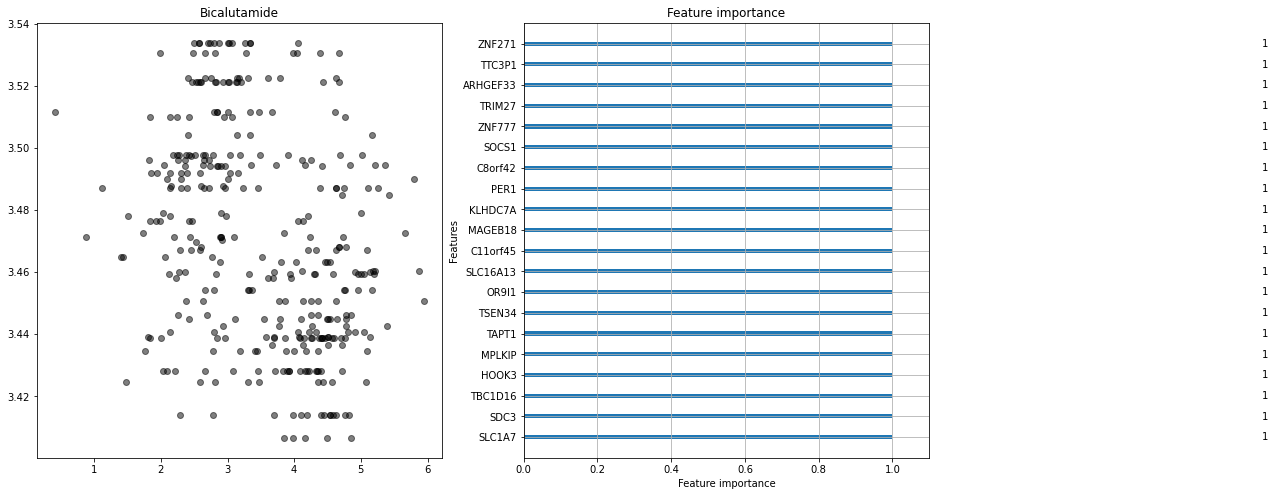

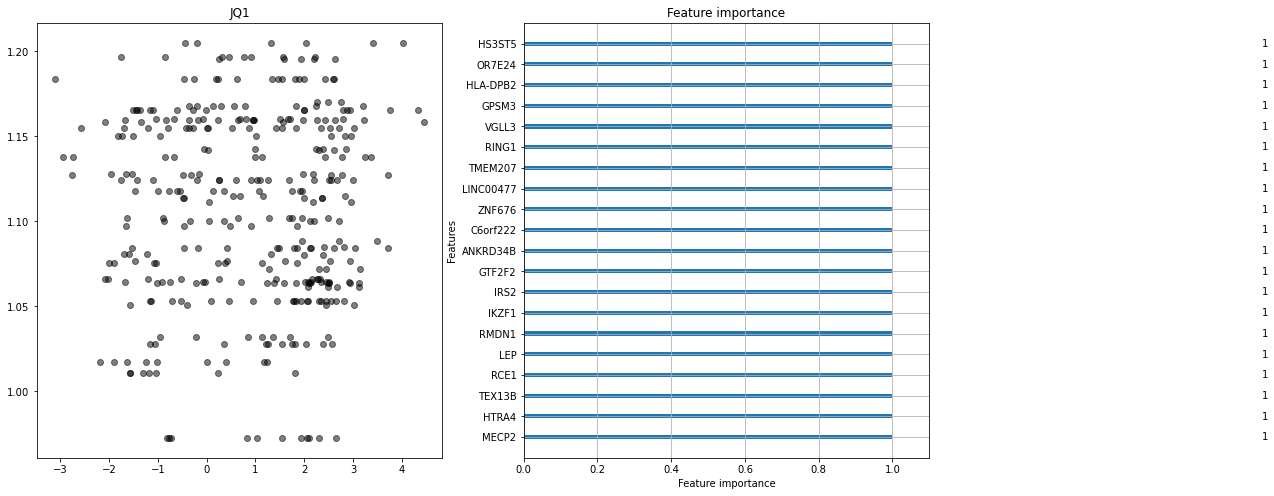

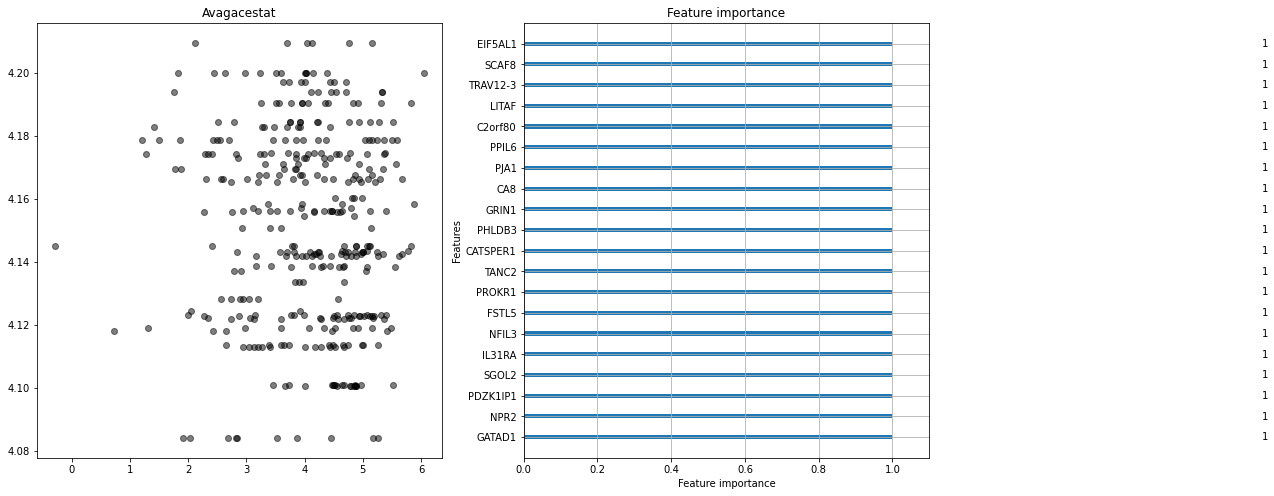

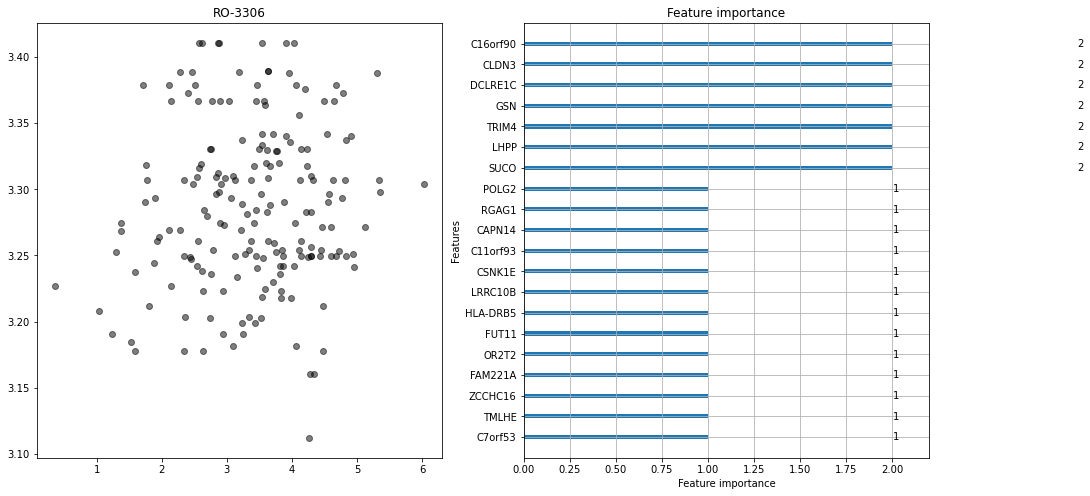

In [163]:
for drug_name in [x for x,y in models_r_sq.items() if y < 0]:
    plot_test(drug_name)

In [164]:
shap.initjs()

In [189]:
def prep_data(drug):
    ic50_sub = ic50_matched.loc[ic50_matched['DRUG_NAME'] == drug][['COSMIC_ID',
                                                                    'LN_IC50',
                                                                    'Z_SCORE']]
    df = pd.merge(ic50_sub, rma_expr_matched).set_index('COSMIC_ID')
    
    return df.drop(['LN_IC50', 'Z_SCORE'], axis = 1)

def plot_shap(drug):
    model = all_models[drug][0]
    X = prep_data(drug)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, title = drug)

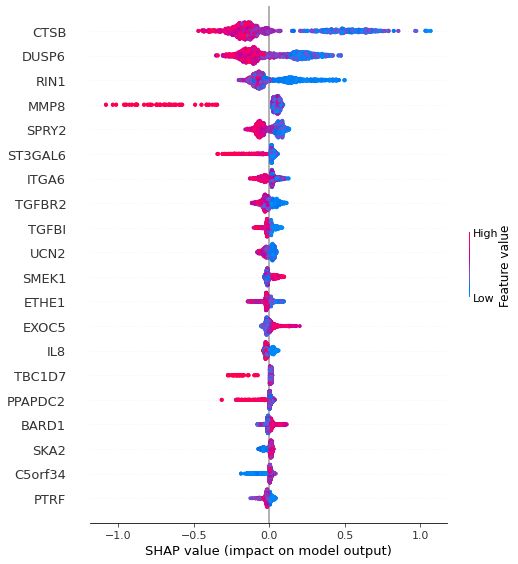

In [190]:
plot_shap('Refametinib')

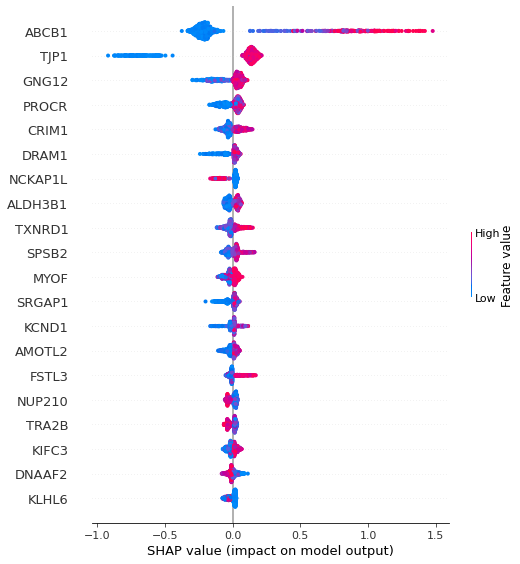

In [191]:
plot_shap('WZ3105')

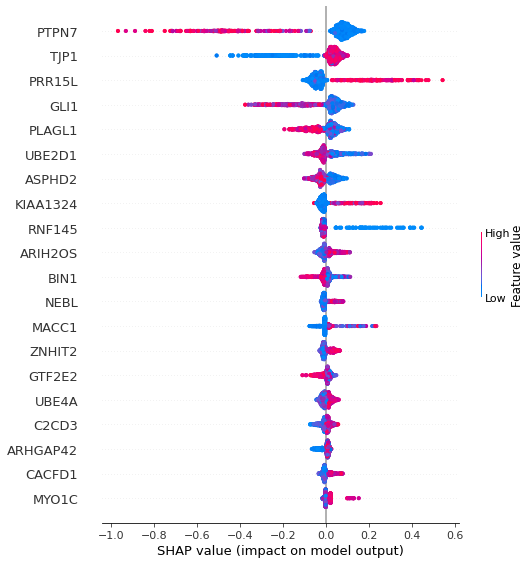

In [192]:
plot_shap('AZD7762')

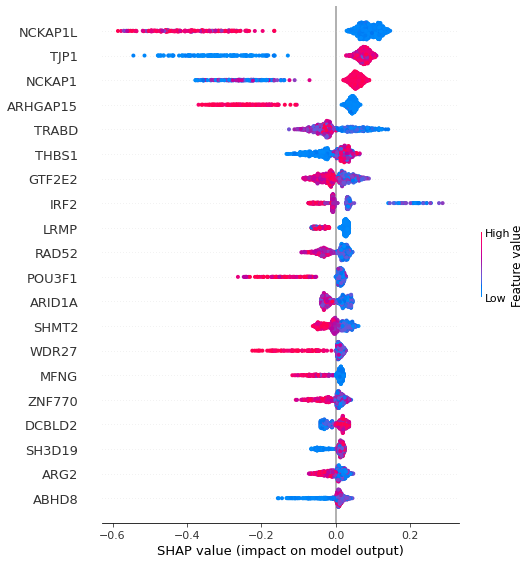

In [194]:
plot_shap('Methotrexate')

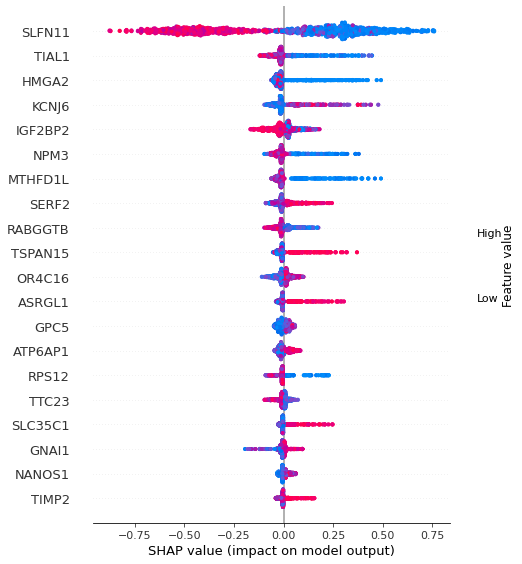

In [195]:
plot_shap('Gemcitabine')

In [196]:
models_r_sq['Gemcitabine']

0.12021500696819098